In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

# Chargement des données
## Choix des variables

In [3]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
m=5

## Constitution des tableaux
### Données brutes

In [4]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=fpd.PIV(prof,manips)#données pour la profondeur

P=fpd.nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=fpd.donnees2(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(57):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z_2D))

z_3D=np.hstack((z_2D,z_2D))
for i in range(57):
    z_3D=np.hstack((z_3D,z_2D))
z_3D=np.reshape(z_3D,(P,59,59))
print(np.shape(z_3D))

(49, 60, 60) (49, 60, 60) (49, 60, 60) (49, 60, 60) (49,)
(49, 59)
(49, 59, 59)


### Divergence

In [5]:
div_2D=np.zeros((P,59,59))
dx=np.zeros((P,59,59))
dy=np.zeros((P,59,59))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
    
print(np.shape(div_2D))

(49, 59, 59)


### vz

In [6]:
vz=fpd.methode_Galerkine(u,v,x,y,z,P,m,prof)
print(np.shape(vz))

(49, 59, 59)


# Test de la divergence 3D
## Dérivation de vz

In [7]:
def deriv3D(vz,z,axis):
    """Dérive un tableau 3D y par rapport à x suivant un axe donné"""
    if vz.shape!=z.shape:
        z_good_shape=z[:-1,:,:]
    else:
        z_good_shape=z
    if axis==0:
        dvz=(vz[1:,:,:]-vz[:-1,:,:])/(z_good_shape[1:,:,:]-z_good_shape[:-1,:,:])#Donc là le tableau est de taille (P-1,n,n)
        return(dvz)

In [8]:
dvz1=deriv3D(vz,z_3D,0)
print(np.shape(dvz1))
print(np.max(div_2D))

(48, 59, 59)
3.3010507364265287


## Avec la méthode Galerkine

\partial_{z}v_{z}= -Ma

In [9]:
def dvz_methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],2)
    #Matrice pinv
    M=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)]))
    pinv=nppinv(M)
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de dvz
    dvz=-np.matmul(M,a)
    dvz=np.reshape(dvz,(P,59,59))
    return(dvz)

In [10]:
dvz=dvz_methode_Galerkine(u,v,x,y,z,P,m,prof)

## Remise des tableaux à la bonne shape

In [11]:
#div_3D=np.zeros(np.shape(div_2D[:-1,:,:]
print(np.shape(div_2D),np.shape(dvz1))

div_3D1=div_2D[:-1,:,:]+dvz1
div_3D=div_2D+dvz

print(np.max(div_3D))
print(div_3D)

(49, 59, 59) (48, 59, 59)
2.1398461229155643
[[[ 4.88162822e-03  8.33697306e-03  1.02285652e-02 ...  4.40448282e-02
   -3.34025234e-03 -5.50888236e-02]
  [ 5.65401229e-03  9.28193225e-03  1.12372917e-02 ...  4.64218769e-02
    9.06799616e-03 -3.12764293e-02]
  [ 6.30395705e-03  1.01048928e-02  1.20001556e-02 ...  3.87047228e-02
    4.24379073e-03 -3.26604802e-02]
  ...
  [-1.63806446e-01 -1.33907705e-01 -7.97879943e-02 ...  2.37285950e-02
    2.14444490e-02  8.95606458e-03]
  [-2.09042266e-01 -1.42814583e-01 -7.20357353e-02 ...  2.87841858e-02
    2.59459529e-02  8.72920843e-03]
  [-1.00557865e-01 -8.49197575e-02 -5.72268274e-02 ...  2.41043386e-02
    2.65941331e-02  1.16573376e-02]]

 [[ 4.65206323e-03  7.96628678e-03  9.84642523e-03 ...  6.27601240e-03
    5.77075906e-03  3.16650905e-03]
  [ 5.35004251e-03  8.81247757e-03  1.07587030e-02 ...  5.08412546e-03
    4.51402940e-03  2.02750213e-03]
  [ 5.87106000e-03  9.47199377e-03  1.13716104e-02 ...  4.59778639e-03
    4.07533461e-03  

In [12]:
#print(div_3D)
print(np.allclose(div_3D,np.zeros(np.shape(div_3D))))

False


# Point de pompage
## Evolution de la position en fonction de la hauteur
### Fonction

In [13]:
def indices_x_y_max(div,P):
    indices=np.zeros((P,2))
    for i in range(P):
        indices[i] = np.unravel_index(np.argmax(div[i], axis=None), (P,59))
    return(indices)

### Constitution des tableaux

In [37]:
x_ind,y_ind=indices_x_y_max(div_2D,P)[:,0],indices_x_y_max(div_2D,P)[:,1]
print(x_ind)
print(indices_x_y_max(div_2D,P))

[24. 24. 24. 24. 24. 28. 20. 17. 29. 29. 29. 27. 29. 28. 27. 27. 28. 27.
 28. 27. 26. 28. 27. 27. 27. 27. 28. 27. 27. 27. 27. 39. 27. 27. 26. 27.
 27. 26. 26. 27. 27. 27. 26. 27. 27.  0. 27. 27. 27.]
[[24. 28.]
 [24. 29.]
 [24. 30.]
 [24. 29.]
 [24. 29.]
 [28. 32.]
 [20. 30.]
 [17. 26.]
 [29. 33.]
 [29. 25.]
 [29. 32.]
 [27. 31.]
 [29. 33.]
 [28. 32.]
 [27. 31.]
 [27. 31.]
 [28. 32.]
 [27. 31.]
 [28. 32.]
 [27. 31.]
 [26. 29.]
 [28. 32.]
 [27. 27.]
 [27. 31.]
 [27. 27.]
 [27. 31.]
 [28. 32.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [39.  7.]
 [27. 31.]
 [27. 31.]
 [26. 30.]
 [27. 31.]
 [27. 31.]
 [26. 29.]
 [26. 29.]
 [27. 31.]
 [27. 31.]
 [27. 31.]
 [26. 29.]
 [27. 31.]
 [27. 31.]
 [ 0. 44.]
 [27. 21.]
 [27. 31.]
 [27. 31.]]


### plot
#### fonction de plot

In [38]:
def plot_indices(indices,z,title,xlabel):
    fig,ax=plt.subplots(num=title)
    ax.plot(indices,z,color='blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('z')
    plt.show()

#### Evolution en x

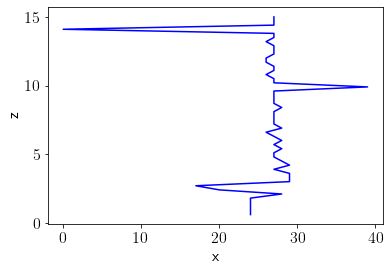

In [39]:
plot_indices(x_ind,z,'title','x')

#### Evolution en y

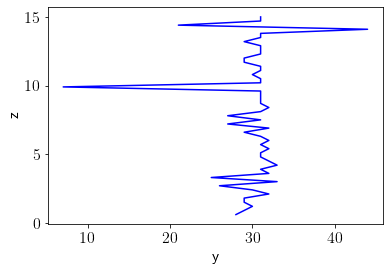

In [40]:
plot_indices(y_ind,z,'title','y')

## Indices des premiers max
### Fonction

In [15]:
def points_de_pompage(div,nmax):
    indices=np.zeros((nmax,3))
    maximums=np.zeros((nmax))
    new_div=np.copy(div)
    for i in range(nmax):
        indices[i] = np.unravel_index(np.argmax(new_div, axis=None), div_2D.shape)
        maximums[i]=np.max(new_div)
        new_div=np.where(new_div==maximums[i],0,new_div)
    return(maximums,indices)

### Constitution des tableaux

In [16]:
nmax=20 #Choix de nmax
maximums,indices=points_de_pompage(div_2D,nmax)
    
print(indices)
print(maximums)

[[ 0. 24. 28.]
 [ 0. 24. 27.]
 [ 0. 24. 29.]
 [ 0. 25. 28.]
 [ 3. 24. 29.]
 [ 0. 23. 28.]
 [ 0. 25. 27.]
 [ 0. 24. 30.]
 [ 3. 24. 30.]
 [ 0. 23. 27.]
 [ 0. 23. 29.]
 [ 1. 24. 29.]
 [ 1. 24. 28.]
 [ 1. 25. 28.]
 [ 3. 25. 30.]
 [ 3. 24. 28.]
 [ 0. 25. 29.]
 [ 0. 23. 30.]
 [ 2. 24. 30.]
 [ 1. 24. 30.]]
[3.30105074 3.1249595  3.08234289 3.03280917 2.96931126 2.92738134
 2.89681874 2.89437129 2.84765465 2.8181298  2.76367274 2.75852015
 2.74313682 2.71487184 2.70850224 2.70477256 2.69225874 2.65851075
 2.65646282 2.62893856]


## Maximum de la dérivée de la divergence
### Fonction

In [17]:
ddiv=deriv3D(div_3D,z_3D,0)
print(np.shape(z_3D),np.shape(div_3D))
print(np.shape(ddiv))

(49, 59, 59) (49, 59, 59)
(48, 59, 59)


### Constitution des tableaux

In [18]:
nmax=20
dmaximums,dindices=points_de_pompage(ddiv,nmax)
print(dindices)
print(dmaximums)

[[47. 31. 31.]
 [11. 32. 29.]
 [46. 27. 31.]
 [11. 31. 31.]
 [11. 32. 30.]
 [47. 32. 29.]
 [36. 26. 29.]
 [36. 26. 30.]
 [46. 26. 29.]
 [23. 31. 31.]
 [44. 31. 31.]
 [24. 27. 31.]
 [47. 32. 30.]
 [43. 26. 29.]
 [33. 31. 31.]
 [36. 27. 31.]
 [43. 27. 31.]
 [46. 26. 30.]
 [43. 26. 30.]
 [47. 32. 28.]]
[7.90859847 7.6061079  7.42482654 7.31338626 7.03611354 6.50291995
 6.39479317 6.25396917 6.23880466 5.88716312 5.87784768 5.57199816
 5.49710957 5.32348873 5.1592166  5.11726394 5.00836888 4.92945502
 4.9004442  4.66463664]
